<h1 style="font-size:30px;">Lane Detection Pipeline for a Still Image</h1> 

This notebook create a pipeline for Lane Detection using OpenCV on a single frame. 

* Create a threshold for lane lines
* Selecting Region of Interest
* Detecting Edges using Canny Edge Detector
* Fit lines using Hough Line Transform
* Extrapolate the lanes from lines found
* Composite the result original frame

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline


In [10]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [12]:
def separate_left_right_lines(lines):
    """Separate left and right lines depending on the slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2: # Negative slope = left lane.
                    left_lines.append([x1, y1, x2, y2])
                elif y1 < y2: # Positive slope = right lane.
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

In [13]:
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == 'NoneType'):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n

In [14]:
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            slope = (y1-y2) / (x1-x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)
    
    # Calculate average intersection at lower_border.
    x_lane_lower_point = int((lower_border - avg_consts) / avg_slope)
    
    # Calculate average intersection at upper_border.
    x_lane_upper_point = int((upper_border - avg_consts) / avg_slope)
    
    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

Program to detect lane markings in the "LaneImages" folder 


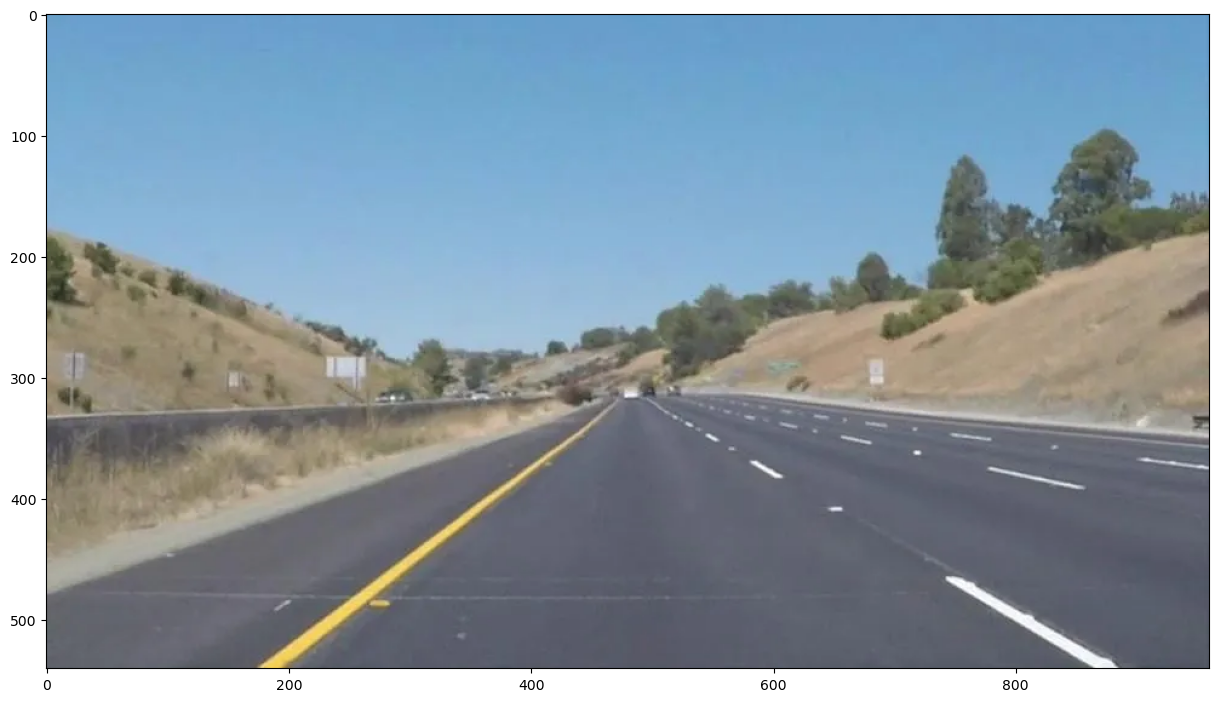

In [55]:
# Read and show an image in LaneImages folder
lane_img = cv2.imread('./LaneImages/lane1.webp')
plt.figure(figsize = (15, 10))
plt.imshow(lane_img[:,:,::-1]);

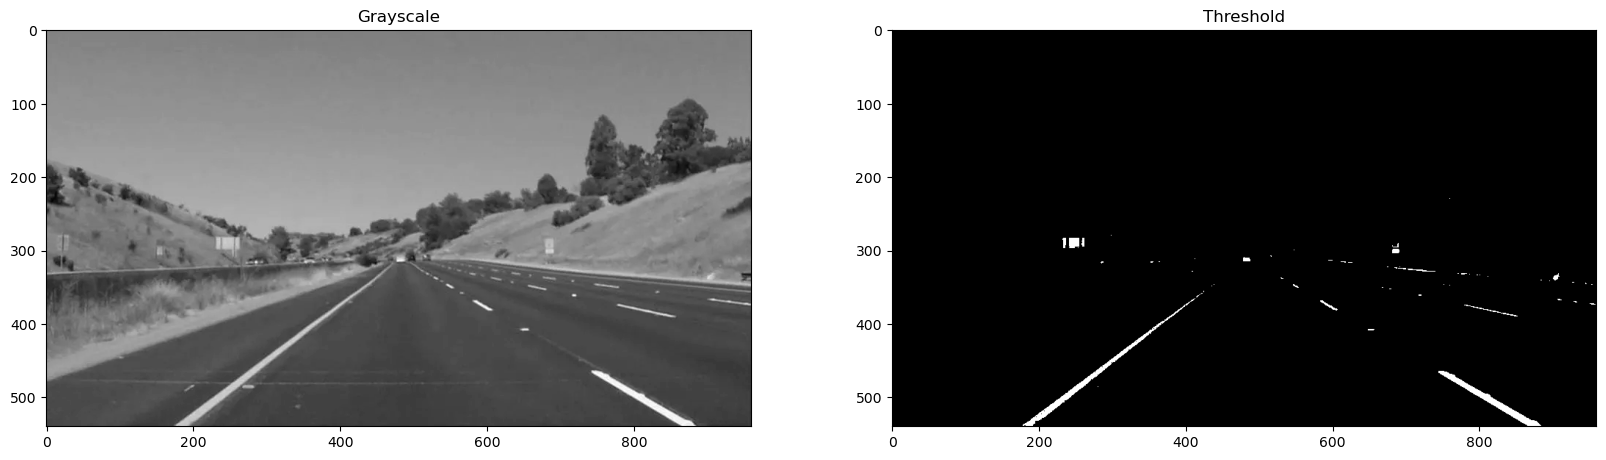

In [56]:
# Convert to grayscale.
lane_gray = cv2.cvtColor(lane_img, cv2.COLOR_BGR2GRAY)
# Use global threshold based on grayscale intensity.
lane_threshold = cv2.inRange(lane_gray, 200, 310)
# Display images
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(lane_gray, cmap = 'gray');      plt.title('Grayscale');
plt.subplot(1,2,2); plt.imshow(lane_threshold, cmap = 'gray'); plt.title('Threshold');

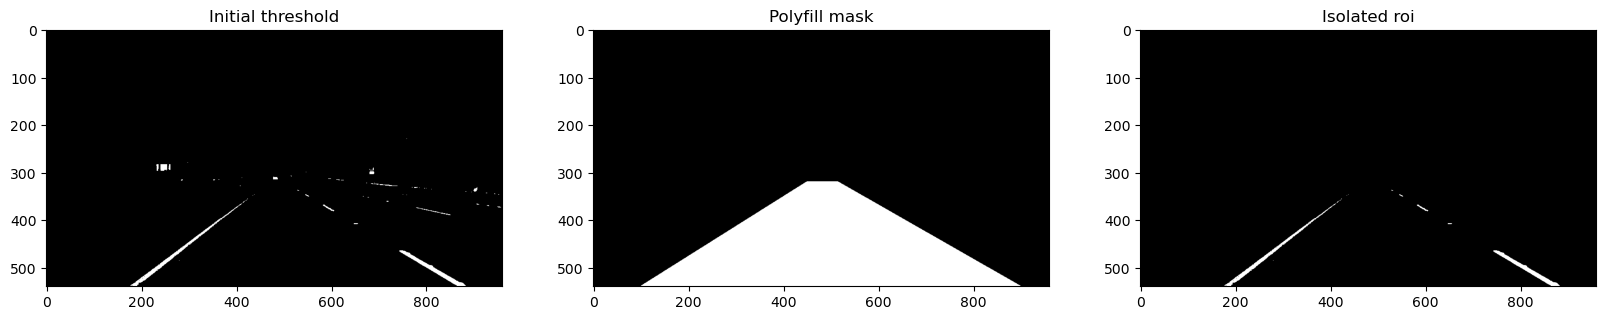

In [57]:
 #  Region masking: Select vertices according to the input image.
roi_vertices_1 = np.array([[[100, 540],
                          [900, 540],
                          [515, 320],
                          [450, 320]]])
# Defining a blank mask.
mask_1 = np.zeros_like(lane_threshold)
# Defining a 3 channel or 1 channel color to fill the mask.
if len(lane_threshold.shape) > 2:
    channel_count = lane_threshold.shape[2]  # 3 or 4 depending on the image.
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255
# Filling pixels inside the polygon.
cv2.fillPoly(mask_1, roi_vertices_1, ignore_mask_color)
# Constructing the region of interest based on where mask pixels are nonzero.
roi_1 = cv2.bitwise_and(lane_threshold, mask_1)
# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(lane_threshold, cmap = 'gray'); plt.title('Initial threshold')
plt.subplot(1,3,2); plt.imshow(mask_1, cmap = 'gray');      plt.title('Polyfill mask')
plt.subplot(1,3,3); plt.imshow(roi_1, cmap = 'gray');       plt.title('Isolated roi');

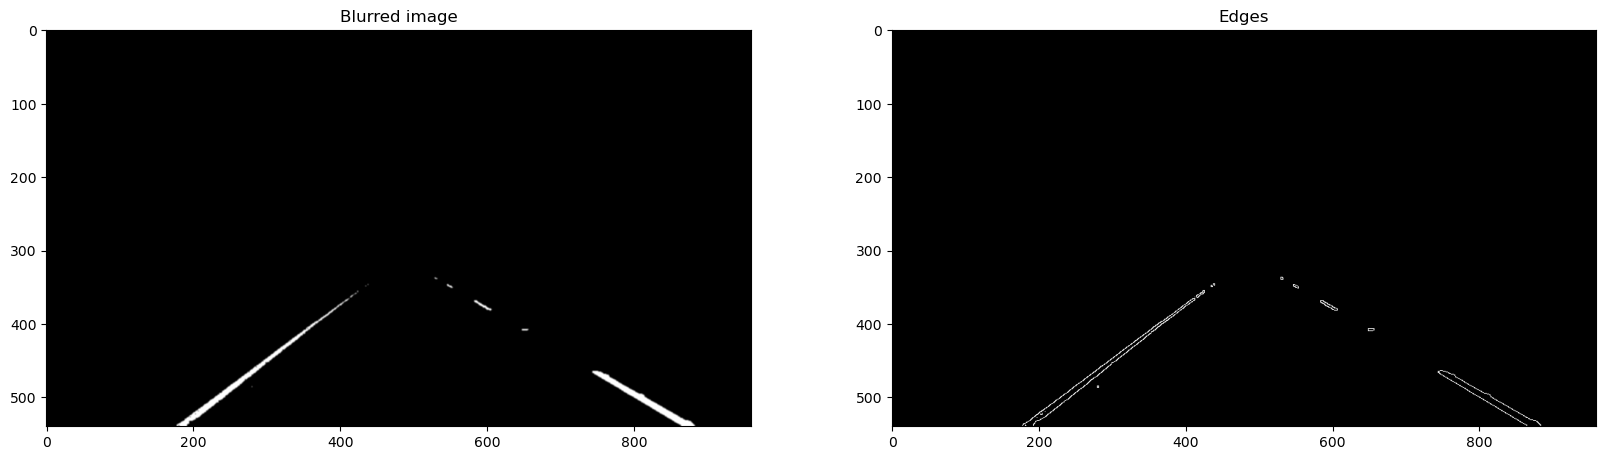

In [58]:
# Smooth with a Gaussian blur.
lane_blurred = cv2.GaussianBlur(roi_1, (3, 3), 0)
# Perform Edge Detection.
lane_canny = cv2.Canny(lane_blurred, 20, 100)
# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(lane_blurred, cmap = 'gray'); plt.title('Blurred image')
plt.subplot(1,2,2); plt.imshow(lane_canny, cmap = 'gray'); plt.title('Edges');

Found 6 lines, including: [[220 508 424 355]]


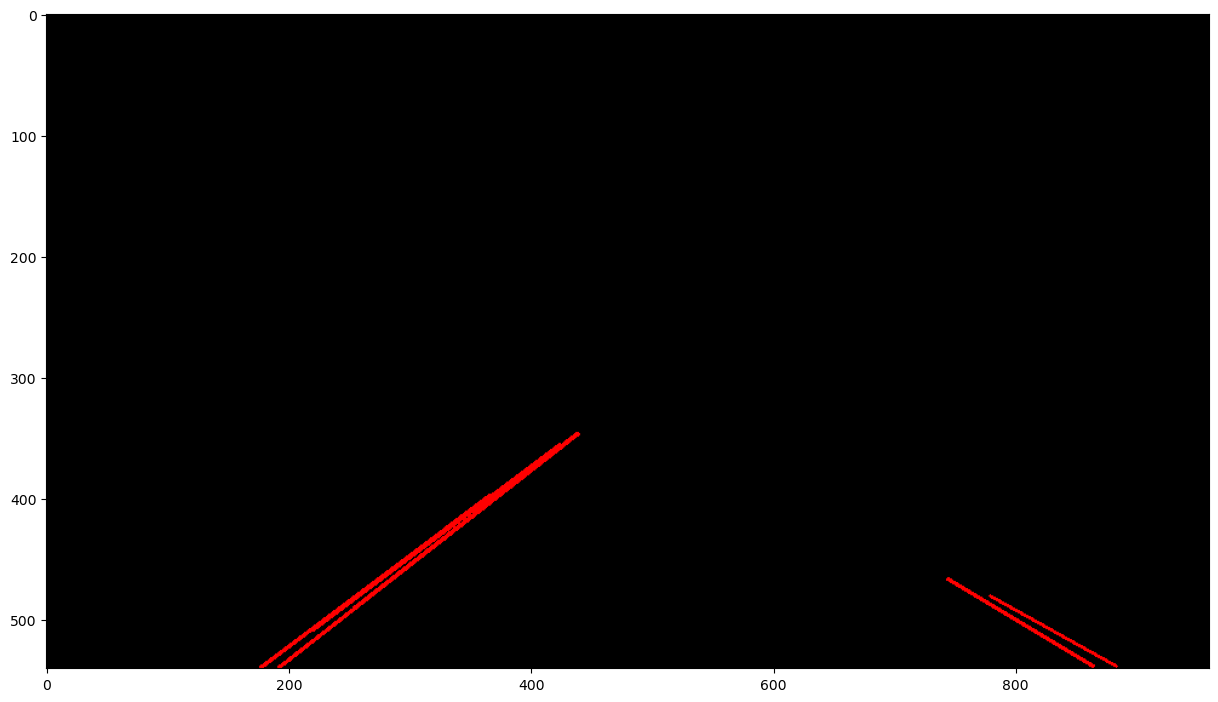

In [59]:
rh0 = 1
theta = np.pi / 180
threshold = 50
min_line_len = 30
max_line_gap = 20

# Hough transform parameters set according to the input image.
lines = cv2.HoughLinesP(lane_canny, rh0, theta, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

# Draw all lines found onto a new image.
hough_1 = np.zeros((lane_img.shape[0], lane_img.shape[1], 3), dtype = np.uint8)
draw_lines(hough_1, lines_1)

print("Found {} lines, including: {}".format(len(lines_1), lines_1[0]))
plt.figure(figsize = (15, 10)); plt.imshow(hough_1);

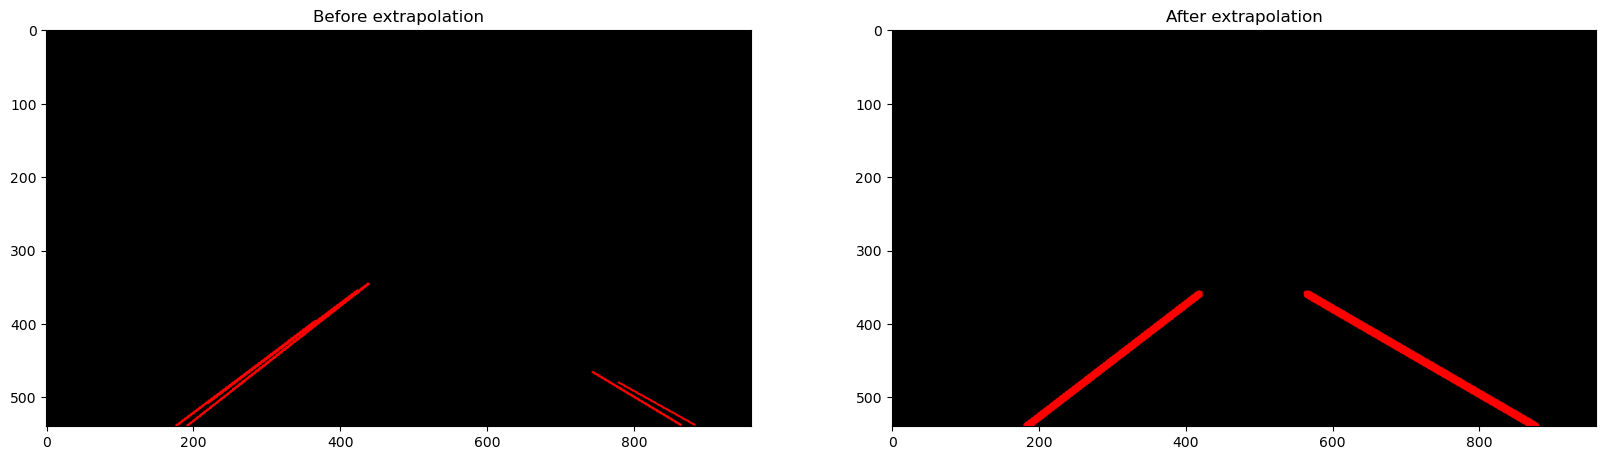

In [60]:
# Defined bounds of the region of interest.
roi_upper_border = 360
roi_lower_border = 540
# Create a blank array to contain the (colorized) results.
lanes_img_1 = np.zeros((lane_img.shape[0], lane_img.shape[1], 3), dtype = np.uint8)
# Use above defined function to identify lists of left-sided and right-sided lines.
lines_left_1, lines_right_1 = separate_left_right_lines(lines_1)
# Use above defined function to extrapolate the lists of lines into recognized lanes.
lane_left_1 = extrapolate_lines(lines_left_1, roi_upper_border, roi_lower_border)
lane_right_1 = extrapolate_lines(lines_right_1, roi_upper_border, roi_lower_border)
draw_lines(lanes_img_1, [[lane_left_1]], thickness = 10)
draw_lines(lanes_img_1, [[lane_right_1]], thickness = 10)
# Display results.
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(hough_1); ax.set_title('Before extrapolation')
ax = fig.add_subplot(1, 2, 2); plt.imshow(lanes_img_1); ax.set_title('After extrapolation');
plt.show()

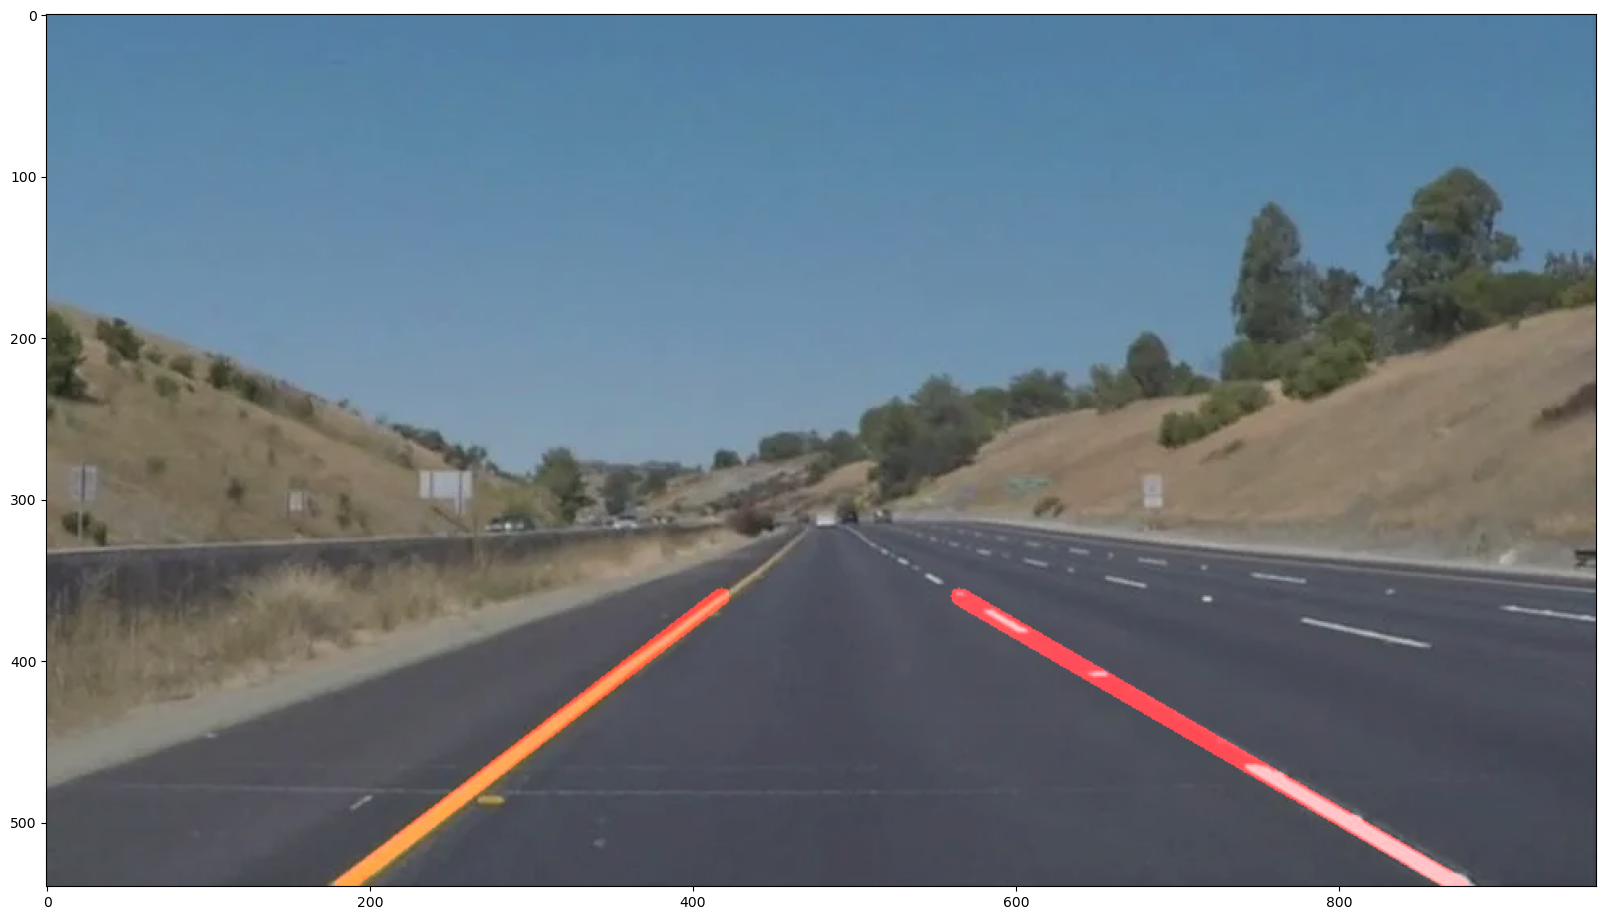

In [61]:
# Blend the resutls with the original image.
alpha = 0.8
beta = 1.0
gamma = 0.0
lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)
image_annotated_1 = cv2.addWeighted(lane_img, alpha, lanes_img_1, beta, gamma)
# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated_1)
image_annotated_1 = cv2.cvtColor(image_annotated_1, cv2.COLOR_BGR2RGB)
plt.savefig('./Lane1-image.jpg');

## THE PROGRAM TO DETECT LANEIMAGES

In [17]:
def lane_detection(image, roi_vertices, lowerb, upperb, threshold_ ,min_line_len, max_line_gap, roi_upper_border, roi_lower_border):
    '''Function to detect lanes in an image.'''
    # Convert to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Use global threshold based on grayscale intensity.
    threshold = cv2.inRange(gray, lowerb, upperb)
    
    # Defining a blank mask.
    mask = np.zeros_like(threshold)
    # Defining a 3 channel or 1 channel color to fill the mask.
    if len(threshold.shape) > 2:
        channel_count = threshold.shape[2]  # 3 or 4 depending on the image.
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon.
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    # Constructing the region of interest based on where mask pixels are nonzero.
    roi = cv2.bitwise_and(threshold, mask)
    # Smooth with a Gaussian blur.
    kernel_size = 3
    roi_blur = cv2.GaussianBlur(roi, (kernel_size, kernel_size), 0)
    
    # Perform Edge Detection.
    low_threshold = 50
    high_threshold = 100
    
    canny_blur = cv2.Canny(roi_blur, low_threshold, high_threshold)
    # Hough transform parameters set according to the input image.
    rho = 1
    theta = np.pi / 180

    lines = cv2.HoughLinesP(
        canny_blur, rho, theta, threshold_, minLineLength = min_line_len, maxLineGap = max_line_gap)
    
    # Create a blank array to contain the (colorized) results.
    lanes_img = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
    draw_lines(lanes_img, lines)
    
    # Create a blank array to contain the (colorized) results.
    lanes_img = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)    
    # Use above defined function to identify lists of left-sided and right-sided lines.        
    lines_left, lines_right = separate_left_right_lines(lines)
    # Use above defined function to extrapolate the lists of lines into recognized lanes.
    lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
    lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)
    draw_lines(lanes_img, [[lane_left]], thickness = 10)
    draw_lines(lanes_img, [[lane_right]], thickness = 10)
    
    # Blend the resutls with the original image.
    alpha = 0.8
    beta = 1.0
    gamma = 0.0
    lanes_img = cv2.cvtColor(lanes_img, cv2.COLOR_BGR2RGB)
    image_annotated = cv2.addWeighted(image, alpha, lanes_img, beta, gamma) 
    image_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB) 
    
    
    return threshold, roi, canny_blur, lines, lanes_img, image_annotated

### Lane 1

In [26]:
img_1 = cv2.imread('./LaneImages/lane1.webp')
roi_vertices_1 = np.array([[
                            [100, 540],
                            [900, 540],
                            [515, 320], 
                            [450, 320]]])
threshold_1, roi_1, canny_blur_1, lines_1, lanes_img_1,image_annotated_1 = lane_detection(img_1,roi_vertices_1, 200, 310, 50, 30, 20, 360, 540)

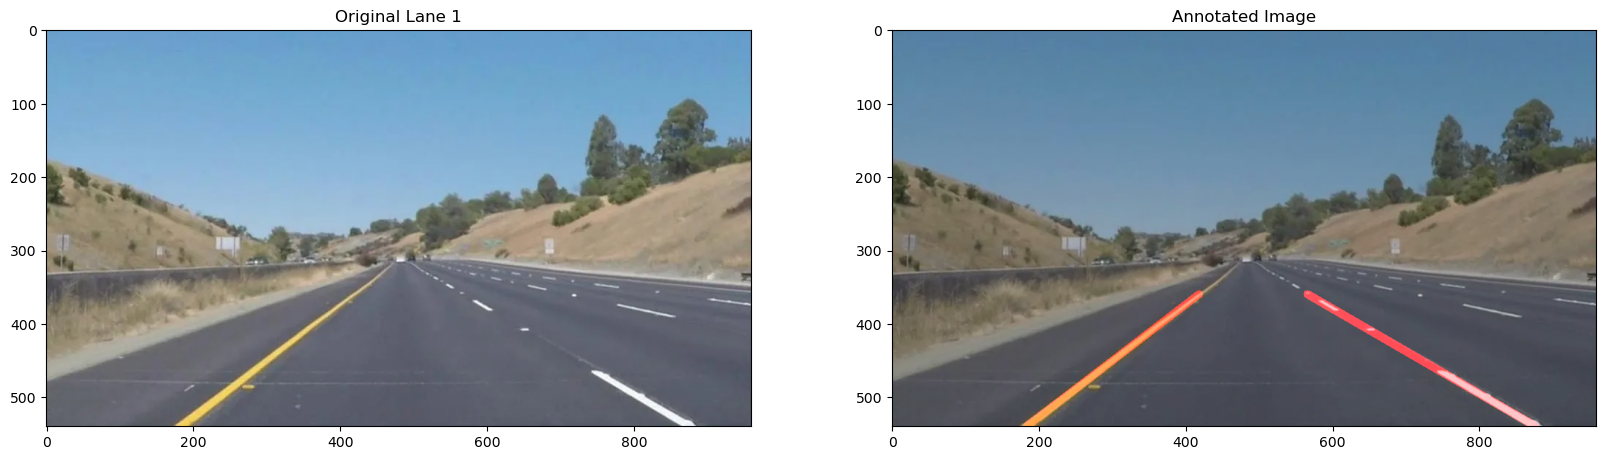

In [27]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(img_1[:,:,::-1]); ax.set_title('Original Lane 1')
ax = fig.add_subplot(1, 2, 2); plt.imshow(image_annotated_1); ax.set_title('Annotated Image');
plt.show()

### Lane 2

In [21]:
img_2 = cv2.imread('./LaneImages/lane2.webp')
roi_vertices_2 = np.array([[[50, 360],
                          [600, 360],
                          [400, 200],
                          [250, 200]]])
threshold_2, roi_2, canny_blur_2, lines_2, lanes_img_2,image_annotated_2 = lane_detection(img_2,roi_vertices_2, 200, 310, 50, 30, 20, 250, 360)

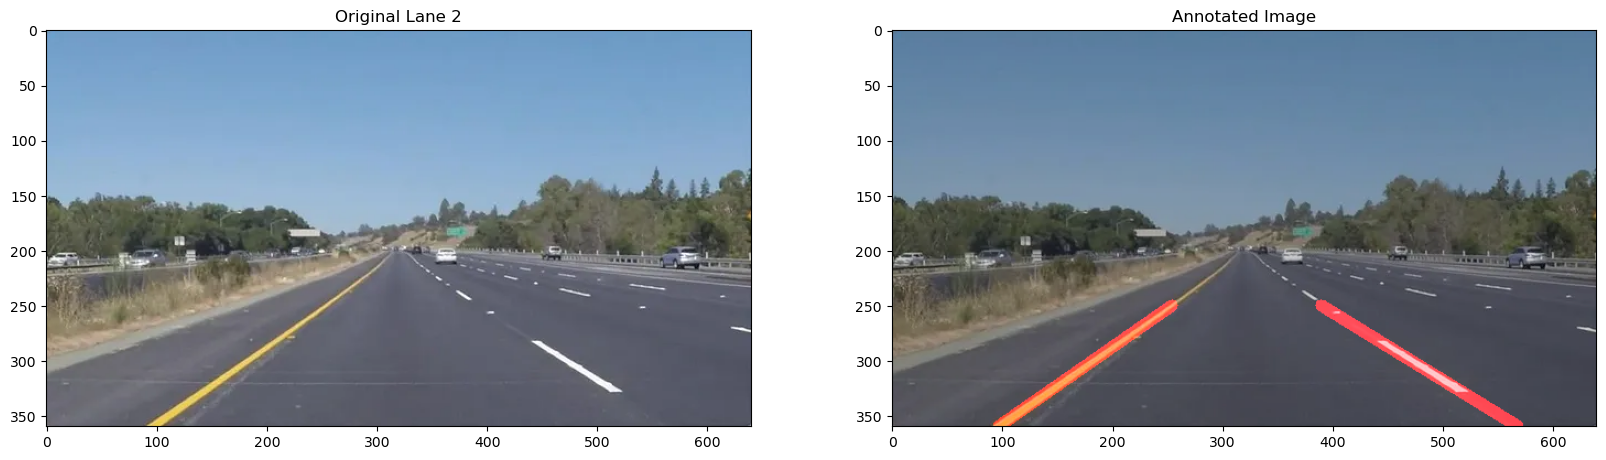

In [130]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(img_2[:,:,::-1]); ax.set_title('Original Lane 2')
ax = fig.add_subplot(1, 2, 2); plt.imshow(image_annotated_2); ax.set_title('Annotated Image');

### Lane 3

In [22]:
img_3 = cv2.imread('./LaneImages/lane3.webp')
roi_vertices_3 = np.array([[
    [100, 540],  
    [900, 540], 
    [550, 300], 
    [350, 300]  
]])
threshold_3, roi_3, canny_blur_3, lines_3, lanes_img_3,image_annotated_3 = lane_detection(img_3,roi_vertices_3, 200, 310, 50, 30, 30, 320, 570)

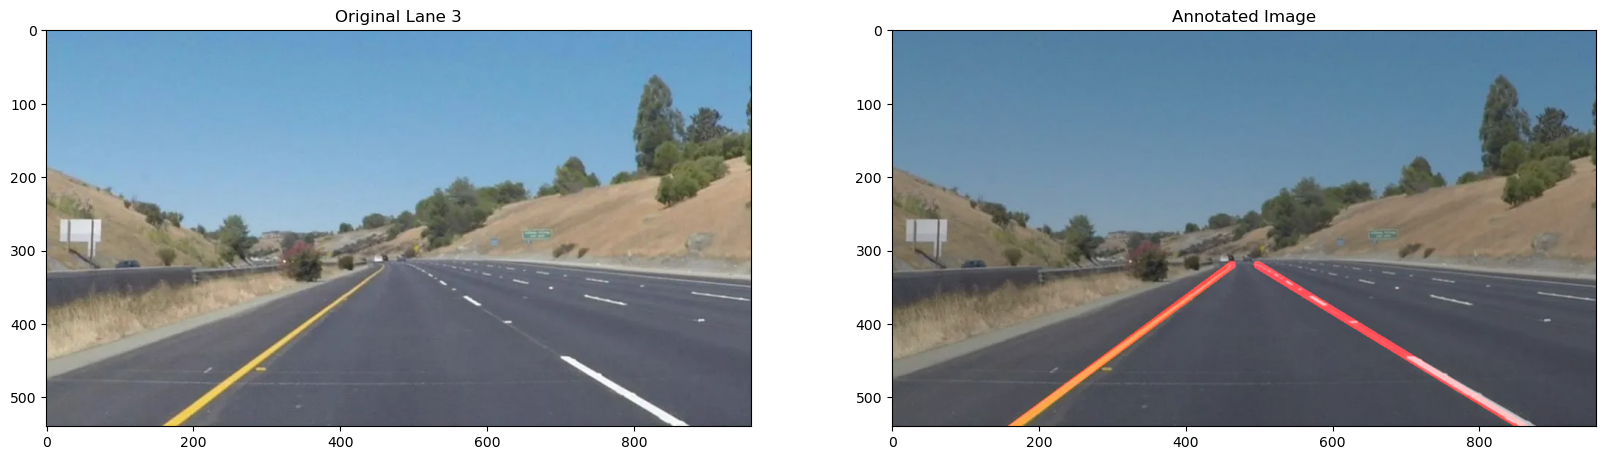

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_3[:, :, ::-1])
axes[0].set_title('Original Lane 3')
axes[1].imshow(image_annotated_3) 
axes[1].set_title('Annotated Image')
plt.show()

### Lane 4

In [23]:
img_4 = cv2.imread('./LaneImages/lane4.webp')
roi_vertices_4 = np.array([[
    [50, 370],  
    [550, 370], 
    [450, 150], 
    [200, 150]  
]], dtype=np.int32)
threshold_4, roi_4, canny_blur_4, lines_4, lanes_img_4,image_annotated_4 = lane_detection(img_4,roi_vertices_4, 200, 310, 35, 30, 30, 230, 360)

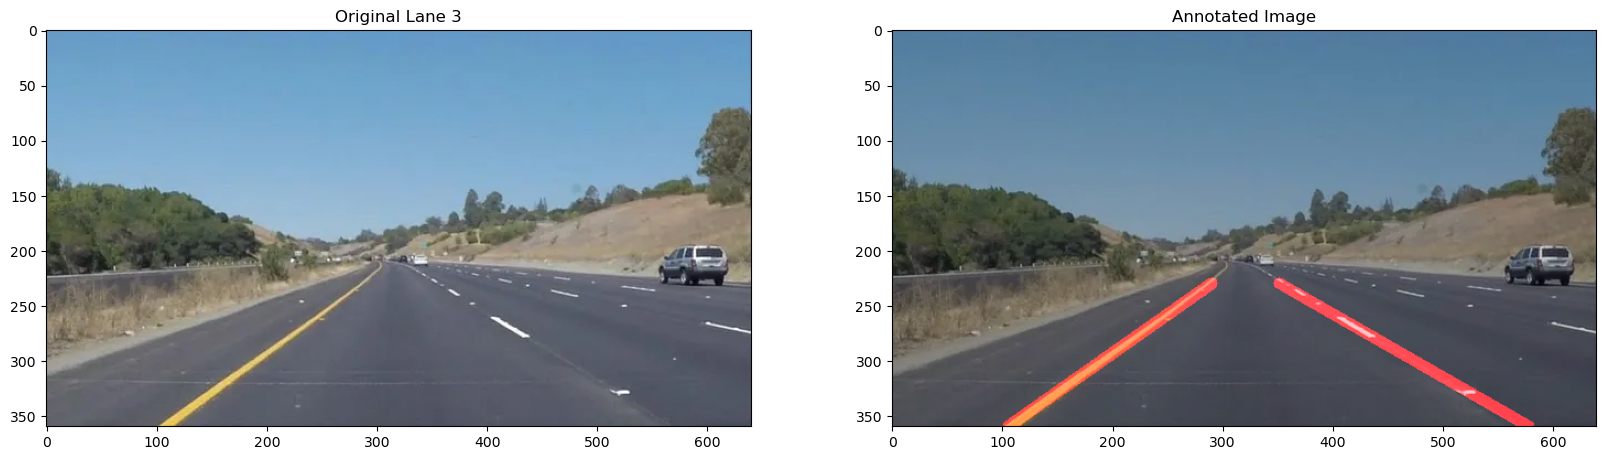

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_4[:, :, ::-1])
axes[0].set_title('Original Lane 3')
axes[1].imshow(image_annotated_4) 
axes[1].set_title('Annotated Image')
plt.show()

### Lane 5

In [24]:
img_5 = cv2.imread('./LaneImages/lane5.webp')
roi_vertices_5 = np.array([[
    [50, 370],  
    [550, 370], 
    [450, 150], 
    [200, 150]  
]], dtype=np.int32)
threshold_5, roi_5, canny_blur_5, lines_5, lanes_img_5,image_annotated_5 = lane_detection(img_5,roi_vertices_5, 200, 310, 35, 30, 30, 230, 360)

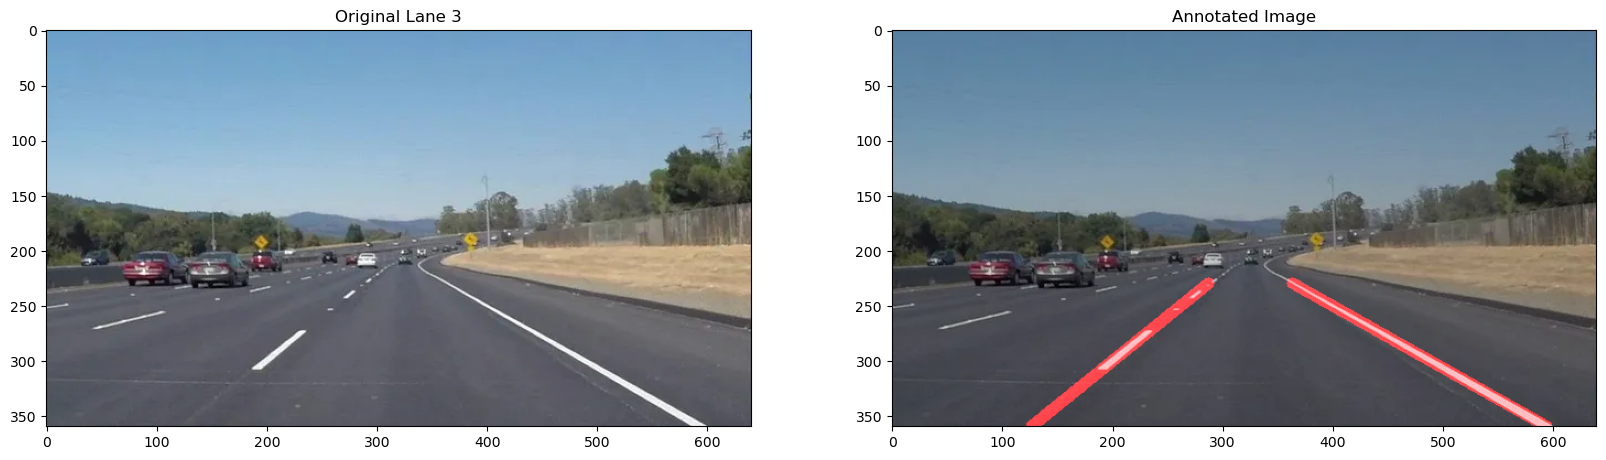

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_5[:, :, ::-1])
axes[0].set_title('Original Lane 3')
axes[1].imshow(image_annotated_5) 
axes[1].set_title('Annotated Image')
plt.show()

### Lane 6

In [25]:
img_6 = cv2.imread('./LaneImages/lane6.webp')
roi_vertices_6 = np.array([[
    [50, 370],  
    [550, 370], 
    [450, 150], 
    [200, 150]  
]], dtype=np.int32)
threshold_6, roi_6, canny_blur_6, lines_6, lanes_img_6,image_annotated_6 = lane_detection(img_6,roi_vertices_6, 200, 310, 35, 30, 30, 230, 360)

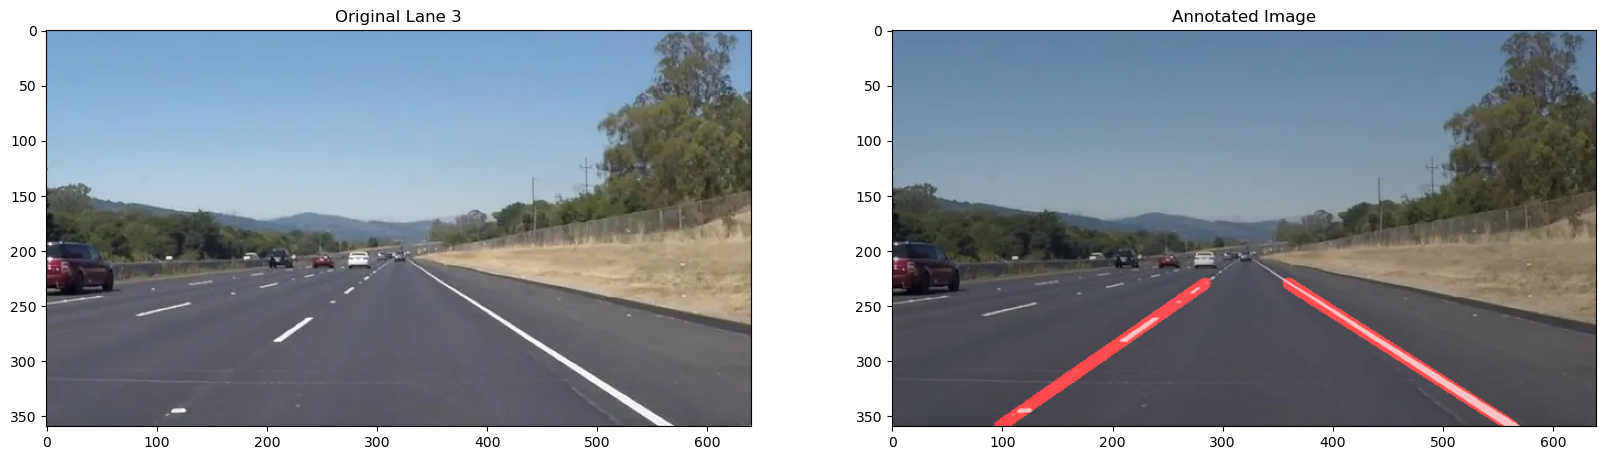

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_6[:, :, ::-1])
axes[0].set_title('Original Lane 3')
axes[1].imshow(image_annotated_6) 
axes[1].set_title('Annotated Image')
plt.show()